# NNET

This is my Jupyter notebook with notes / implementation of a neural network in Julia. All materials are based on deeplearning.ai's Deep Learning Specialization. I refer to specific videos and other materials where applicable. **The notebook is not yet finished**

I created this notebook to review some of the concepts I learned in the first three courses of the deep learning specialization. Its purpose is primarily for me to process the information and produce the implementation from my own understanding rather than simply copying it from another place. As a result, you may find that the implementation notes are somewhat long-winded or tangential.

If you find a mistake or think this code can be improved, it would be great if you could fork the repository and make a pull request. You could also leave a comment in the issues section.

### This notebook contains

- Loading & pre-processing the MNIST dataset
- forward and backward propagation using a n-layer neural network
- ReLU / sigmoid / 'safe' softmax activation functions
- Inverted dropout implementation
- Xavier / He weight initialization 
- Adam
- Learning rate decay
- mini-batch gradient descent

### References

- I refer to the deep learning specialization course materials where applicable
- I translated some of the numpy code from Jonathan Weisberg's "Building a Neural Network from Scratch" [part I](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%201/) and [part II](https://jonathanweisberg.org/post/A%20Neural%20Network%20from%20Scratch%20-%20Part%202/) to Julia

## Loading the MNIST dataset

The MNIST dataset contains $60.000$ images of digits $1-10$. We use the MLDatasets module to retrieve and load the data. Normally, we would [normalize](https://www.coursera.org/learn/deep-neural-network/lecture/lXv6U/normalizing-inputs) the input data such that it has mean $0$ and standard deviation $1$ (also known as a standard normal distribution). However, this has already been done for this version of the MNIST dataset.

In [194]:
using MLDatasets

# Train & test data
train_x, train_y = MNIST.traindata();
test_x, test_y = MNIST.testdata();

# Note that the data have been normalized already
# See: https://juliaml.github.io/MLDatasets.jl/latest/datasets/MNIST/

The shapes of the data are as follows

In [195]:
## Get shapes
println(size(train_x))
println(size(train_y))
trainsize = size(train_x)[3];

(28, 28, 60000)
(60000,)


I find it easier to think about the data if the examples are in the row dimension. We will reshape the data such that $X$ is a tensor of shape $(60.000, 784)$. 

In [196]:
# Reshape x
train_x = transpose(reshape(train_x, 28 * 28, size(train_x)[3]));
test_x = transpose(reshape(test_x, 28 * 28, size(test_x)[3]));

# Reshape Y
train_y = reshape(train_y, size(train_y)[1], 1);
test_y = reshape(test_y, size(test_y)[1], 1);

In [197]:
using Statistics
size(train_x)

for i = 1:3
    
    println("Mean: ", mean(train_x[i, :]), "\nVar: ", var(train_x[i,:]), "\n")
    
    end;

Mean: 0.13768007202881152
Var: 0.09768609056323807

Mean: 0.1555372148859544
Var: 0.10835898025851963

Mean: 0.09725390156062426
Var: 0.06622370038341628



In [198]:
tt = train_x[1,:]
tt_trans = (tt .- mean(tt)) / sqrt(var(tt))

println("Mean: ", mean(tt_trans), "\nVar: ", var(tt_trans), "\n")

Mean: 2.8463626013986793e-17
Var: 1.0000000000000002



$Y$ has $10$ unique labels ranging from $0-9$. However, this is actually a recoding of the data. MORE

In [199]:
size(train_y)

(60000, 1)

In [200]:
unique(train_y)

10-element Array{Int64,1}:
 5
 0
 4
 1
 9
 2
 3
 6
 7
 8

### The data until now

- $X$ is a tensor with dimension $(60.000, 784)$
- $Y$ is a tensor with dimension $(60.000, 1)$

<img src="img/XandY2.png" width = "500px">

### Creating a one-hot encoding for $Y$

In order to train the neural network, we need to one-hot-encode <link> the outcome variable $Y$.

The trick to doing this is as follows:

- Create a $k \times k$ identity matrix. In our case, we have $k=10$, so:

$$
I = 
\begin{bmatrix}
1 & 0 & \dots & 0 \\
0 & 1 & \dots & 0 \\
\vdots & \vdots & \ddots & 0 \\
0 & 0 & \dots & 1
\end{bmatrix}
$$

- For each example in $Y$, *index the column of the value of the label*. For example, if the the label equals '5', we index the $5^{th}$ column, which has a $1$ on the $5^{th}$ element and zeroes elsewhere

$$
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 
\end{bmatrix}
$$

- Because we do this $n$ times (the number of training examples), we will end up with a tensor of size $(10, 60.000)$

$$
\begin{bmatrix}
0 & 0 & 0 & \dots & 1 \\
1 & 1 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 1 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
0 & 0 & 0 & \dots & 0
\end{bmatrix}
$$

- Again, I like to think in terms of (examples, dimensions) so we will transpose the one-hot-encoded matrix such that it has the dimensions $(60.000, 10)$

<img src="img/y_one_hot.png" width = "300px">

In [201]:
# One-hot encoding for y
# We need a shape for outcome variable of size [num_labels, num_examples]

# Number of distinct classes
k = length(unique(train_y));
# Number of training examples
n = size(train_y)[1];

In [202]:
using LinearAlgebra

function one_hot_encode(y_labels)
    
    #=
    From multiclass labels to one-hot encoding
    
    :param y_labels: column vector of shape (number of examples, 1) containing k > 2 classes
    
    :return: one-hot encoded labels
    =#
    
    # Number of distinct classes
    k = length(unique(y_labels));
    # Number of rows
    n = size(y_labels)[1];
    
    # 1. Create k x k identity matrix 

    # Arrange the identity matrix such that, for each class, we get a one-hot encoded vector.
    # This means that the rows are of length k (the number of distinct classes)
    # The columns are of length n (the number of examples).
    y_ohe = Matrix{Float64}(I, k, k)

    # 2. Organize such that we get a k x m matrix. We do this by letting the label index
    #     the column value. Since we have m labels, we index the columns m times.
    #     So for m = 1.000 where m_1000 = 3, we index the kth column [0,0,1,0,...,k]
    
    # We have to add +1 to the classes (because Julia indexes from 1)
    # Unlike e.g. numpy we need to explicitly call 'broadcast' to match shapes between
    # two elements that we're adding
    y_ohe = y_ohe[:, broadcast(+, y_labels, 1)][:,:];
    
    # Return
    return(y_ohe)
    
    end;

# One-hot encoding
y_train_ohe = transpose(one_hot_encode(train_y));
y_test_ohe = transpose(one_hot_encode(test_y));

println(size(y_train_ohe))
println(size(y_test_ohe))

(60000, 10)
(10000, 10)


just to make sure that the one-hot encoding was done properly, we can randomly sample a number of values and check if the one-hot encoded examples line up with the original labels.

In [203]:
using Random

function sanity(y_ohe, train_y; n_sample = 5)
    
    #=
    Ensure that one-hot encoded labels are encoded properly by transforming them back into
     labels.
    
    :param y_ohe: one-hot encoded training labels
    :param train_y: array of size (examples, 1) containing the labels
    :param n_sample: number of examples to sample randomly
    
    :return: This function does not return a value
    =#
    
    # Shapes
    n, k = size(y_ohe)
    
    # Pick a random example
    ind_shuffled = shuffle(1:n)
    
    # Subset
    ind = ind_shuffled[1:n_sample]
    
    # For each, print OHE + convert back to class
    for i in ind
        
        # Find position of 1
        pos = findall(x -> x==1, y_ohe[i, :])
        
        # Subtract 1
        pos = pos[1] - 1
        
        # Print
        println("Example ", i, ":\n", 
                "\t[OHE position: ", pos, "] ==> [label: ", train_y[i,1], "]")
        
    end
    
end;

In [204]:
sanity(y_train_ohe, train_y)

Example 9455:
	[OHE position: 7] ==> [label: 7]
Example 24470:
	[OHE position: 3] ==> [label: 3]
Example 35866:
	[OHE position: 1] ==> [label: 1]
Example 21226:
	[OHE position: 5] ==> [label: 5]
Example 42609:
	[OHE position: 0] ==> [label: 0]


### NNet functions

Plan: build a neural net with one hidden layer and $n_h$ hidden units

TODO:

- Notation
- Matrix calculus (see https://atmos.washington.edu/~dennis/MatrixCalculus.pdf)
- Images of the neural network structure
- Backprop computation graph image + derivatives
    * Also when using Tanh
- References
    * Chollet Keras
    * Coursera course
- 'safe' softmax function
- dropout

### Cross validation

In [205]:
function cross_validation(X, Y, split_prop = 0.05)
    
    #=
    Create train/test split
    
    :param X: Input data X
    :param Y: output data Y
    :param split_prop: percentage of data to use as validation set
    
    :return: dictionary with train & validation data
    :seealso: https://www.coursera.org/learn/deep-neural-network/lecture/cxG1s/train-dev-test-sets
    =#
    
    # Number of training examples
    trainsize = size(X)[1]
    
    # Number of validation examples
    ndev = Integer(floor(trainsize * split_prop))
    
    # Shuffle indices
    ind = shuffle(1:trainsize);
    # Rearrange train x and y
    X = X[ind, :];
    Y = Y[ind, :];

    # Validation split
    dev_x = X[1:ndev, :];
    dev_y = Y[1:ndev, :];

    # Remove from train
    train_x = X[ndev+1:end, :];
    train_y = Y[ndev+1:end, :];
    
    # To dict
    split = Dict(
        "X_train" => train_x,
        "Y_train" => train_y,
        "X_dev" => dev_x,
        "Y_dev" => dev_y
    )
    
    # Return
    return(split)
    
    end;

### Weight initialization

$$
W^{[l]} = (n^{[l]},n^{[l-1]}) 
$$

In [376]:
function initialize_layer(n_h_current, n_h_last, activation, layer; drop_chance = 0.2, last=false)
    
    #=
    Initialize a layer
    =#
    
    # Weights
    W = randn(n_h_current, n_h_last)
    b = zeros(n_h_current, 1)

    # Weight initialization
    if activation == "ReLU"

        W = W .* sqrt(2 / n_h_last)

    else

        W = W .* sqrt(1 / n_h_last)

        end;
    
    # Initialization for Adam / RMSprop
    vdW = zeros(n_h_current, n_h_last)
    vdb = zeros(n_h_current, 1)
    
    sdW = zeros(n_h_current, n_h_last)
    sdb = zeros(n_h_current, 1)
    
    # To dict
    current_layer = Dict(
        "layer" => layer,
        "last_layer" => last,
        "activation" => activation,
        "hidden_current" => n_h_current,
        "hidden_previous" => n_h_last,
        "W" => W,
        "b" => b,
        "vdW" => vdW,
        "vdb" => vdb,
        "sdW" => sdW,
        "sdb" => sdb
    )
    
    # If last_layer == false, add drop chance
    if last == false
        
        current_layer["keep_prob"] = 1 - drop_chance
        
        end;
    
    # Return
    return(current_layer)
    
    end;

function initialize_parameters(n_x, n_h, n_y, activations, layers, dropout)
    
    #=
    Initialize the weight matrices and bias vectors
    
    :param n_x: number of observations in the input data
    :param n_h1: number of hidden units in the first layer
    :param n_h2: number of hidden units in the second layer
    :param n_y: number of labels in the output data
    
    :return:
       - parameters: dict containing weights W and bias vectors b for each layer
       - cache:      dict containing the moving average of the gradient (first moment) and moving average of the second gradient (second moment)
    
    :seealso: 
       - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/XtFPI/random-initialization
       - https://www.coursera.org/learn/deep-neural-network/lecture/C9iQO/vanishing-exploding-gradients
       - https://www.coursera.org/learn/deep-neural-network/lecture/RwqYe/weight-initialization-for-deep-networks
       - https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network
       - https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94
    =#
    
    # For sigmoid / tanh / softmax --> Xavier weight initialization --> 1 / sqrt(units in previous layer)
    # For ReLU weight initialization --> 2 / sqrt(units in previous layer)
    
    # List to hold results
    layer_details = []
    
    # Add 1 to layers (last layer is the softmax layer)
    layers = layers + 1
    
    # For each layer, initialize
    for layer = 1:layers
        
        # If first layer, then pass the value of n_x
        if layer == 1
            
            # Expect a tuple if layers > 2
            current_layer = initialize_layer(ifelse(layers <= 2, 
                                                    n_h, 
                                                    n_h[1]), 
                                             n_x, 
                                             ifelse(layers <= 2, 
                                                    activations, 
                                                    activations[layer]), 
                                             layer,
                                             drop_chance = ifelse(layers <= 2, 
                                                            dropout, 
                                                            dropout[layer]))
          
        # If last layer, then make it a softmax and pass n_y
        elseif(layer == layers)
            
            current_layer = initialize_layer(n_y, 
                                             ifelse(layers <= 2,
                                                    n_h,
                                                    n_h[layer-1]), 
                                             "softmax",
                                             layer, 
                                             last=true)
        
        # Else, we have the hidden layers in between input X and output Y
        else
            
            current_layer = initialize_layer(n_h[layer], n_h[layer-1], activations[layer], layer,
                                             drop_chance = dropout[layer])
            
            end;
        
        # Push layer
        push!(layer_details, current_layer)
        
        end;
    
    # Return
    return(layer_details)
    
    end;

In [207]:
# Multiple layers
layers_multiple = initialize_parameters(784, (256, 128), 10, ("ReLU", "ReLU"), 2, (0.2, 0.4));
# Single layer
layers_single = initialize_parameters(784, 256, 10, "ReLU", 1, 0.5);

In [208]:
layers_multiple[2]

Dict{String,Any} with 12 entries:
  "W"               => [0.0197382 0.0216007 … -0.0784624 0.0485954; -0.0959504 …
  "b"               => [0.0; 0.0; … ; 0.0; 0.0]
  "keep_prob"       => 0.6
  "vdW"             => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "sdb"             => [0.0; 0.0; … ; 0.0; 0.0]
  "hidden_current"  => 128
  "layer"           => 2
  "activation"      => "ReLU"
  "sdW"             => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "hidden_previous" => 256
  "last_layer"      => false
  "vdb"             => [0.0; 0.0; … ; 0.0; 0.0]

In [209]:
layers_single[1]

Dict{String,Any} with 12 entries:
  "W"               => [-0.0135244 0.0334305 … 0.0225554 0.0404762; -0.0443972 …
  "b"               => [0.0; 0.0; … ; 0.0; 0.0]
  "keep_prob"       => 0.5
  "vdW"             => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "sdb"             => [0.0; 0.0; … ; 0.0; 0.0]
  "hidden_current"  => 256
  "layer"           => 1
  "activation"      => "ReLU"
  "sdW"             => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "hidden_previous" => 784
  "last_layer"      => false
  "vdb"             => [0.0; 0.0; … ; 0.0; 0.0]

### Mini-batch gradient descent

An algorithm for splitting the data into batches is given below. Here:

- $n$ is the number of training examples
- $k$ is the batch size
- $j$ is the number of total batches that can be created **using the batch size $k$**

That is, $j$ is the integer part of the division of $\frac{n}{k}$.

<img src="img/minibatch.png" width = "500px">

This toy example is given as an algorithm below

In [210]:
# Number of examples
n = 101;
# Batch size
k = 10;
# Number of batches of size k (discounting any remainders)
j = floor(n/k);

# For each minibatch
for i = 1:j
    
    # Start at 1 if minibatch is 1
    if i == 1
        index_begin = 1
    else
        # Else start at the end of the previous minibatch plus one
        index_begin = Integer(((i - 1) * k) + 1)
        end;
    
    # End 
    index_end = Integer((i * k))
    
    println("Minibatch ", Integer(i), "\n\t[Begin ", index_begin, "] ==> [end ", index_end, "]")
    
    end;

# If there is a remainder
if n - (j * k) > 0
    
    index_begin = Integer((j * k) + 1)
    index_end = n
    
    println("Minibatch ", Integer(j+1), "\n\t[Begin ", index_begin, "] ==> [end ", index_end, "]")
    
    end;

Minibatch 1
	[Begin 1] ==> [end 10]
Minibatch 2
	[Begin 11] ==> [end 20]
Minibatch 3
	[Begin 21] ==> [end 30]
Minibatch 4
	[Begin 31] ==> [end 40]
Minibatch 5
	[Begin 41] ==> [end 50]
Minibatch 6
	[Begin 51] ==> [end 60]
Minibatch 7
	[Begin 61] ==> [end 70]
Minibatch 8
	[Begin 71] ==> [end 80]
Minibatch 9
	[Begin 81] ==> [end 90]
Minibatch 10
	[Begin 91] ==> [end 100]
Minibatch 11
	[Begin 101] ==> [end 101]


The code below implements mini-batches for real data

In [211]:
function create_batches(X, Y, batch_size = 128)
    
    #=
    Creates b batches of size batch_size
    
    :param X:          input data X
    :param Y:          output data Y
    :param batch_size: size of each batch
    
    :return: list containing m batches of length batch_size and possibly 1 batch of size batch_size_remainder < batch_size
    :seealso: 
      - https://www.coursera.org/learn/deep-neural-network/lecture/qcogH/mini-batch-gradient-descent
      - https://www.coursera.org/learn/deep-neural-network/lecture/lBXu8/understanding-mini-batch-gradient-descent
    =#
    
    # Shuffle training examples randomly
    n = size(X)[1]
    ind = shuffle(1:n)
    
    # Rearrange data in X and Y
    X = X[ind, :]
    Y = Y[ind, :]
    
    # List to store minibatches
    mbatches = []
    
    # Number of complete training examples. 
    #  This means: n / 128 leaves a remainder (most likely)
    #  Therefore, there will be (b - 1) batches with size batch_size
    #  and 1 batch with size last_batch_size < batch_size
    b_first = Integer(floor(n / batch_size))
    
    # First, loop through the (b_first - 1) examples
    #  We need to loop through b_first - 1 because we construct 
    #    @ index_begin => i * batch_size (e.g. 9 * 128 = 1152)
    #    @ index_end => (i + 1) * batch_size (e.g. 10 * 128 = 1280)
    #  index_end needs (i + 1). If i == k where k is the last possible index, we cannot subset index_end
    #  because it would require (k + 1) indices.
    for i = 1:b_first
        
        # Beginning and end indices
        if i == 1
            index_begin = 1
        else
            index_begin = Integer(((i - 1) * batch_size) + 1)
            end;
        
        index_end = Integer(i * (batch_size))
        
        X_current_batch = X[index_begin:index_end, :]
        Y_current_batch = Y[index_begin:index_end, :]

        # Add to array of minibatches
        push!(mbatches, [X_current_batch, Y_current_batch])
        
        end;
    
    # Then, if necessary, make a batch for the remainder
    b_rem = n - (b_first * batch_size)
    if b_rem != 0
        
        # Subset X & Y
        index_begin = Integer(((b_first) * batch_size) + 1) # i+1 is from the for-loop above (i.e. the last 'full' minibatch of size batch_size)
        index_end = n 
        
        X_current_batch = X[index_begin:index_end, :]
        Y_current_batch = Y[index_begin:index_end, :]
        
        # Append
        push!(mbatches, [X_current_batch, Y_current_batch])
        
        end;
    
    # Return mini batches
    return(mbatches)
    
    end;

### Activation functions and Loss function

In [212]:
function softmax(z)
    
    #=
    Softmax function
    
    :param z: result of the linear transformation of the final layer
    :return: activations for z
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4dDC1/activation-functions
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions
      - https://www.coursera.org/learn/deep-neural-network/lecture/HRy7y/softmax-regression
      - https://www.coursera.org/learn/deep-neural-network/lecture/LCsCH/training-a-softmax-classifier
    =#
    
    # Subtract the max of z to avoid exp(z) getting too large
    z = z .- maximum(z)
    
    # Softmax & return
    return(exp.(z) ./ sum(exp.(z),dims=1))
    
    end;

function sigmoid(z)
    
    #=
    Sigmoid function
    
    :param z: result of the linear transformation for layer l
    :return: activations for z
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4dDC1/activation-functions
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions
    =#
    
    1 ./ (1 .+ exp.(-z))
    
    end;

function ReLU(z)
    
    #=
    ReLU implementation
    
    :param z: result of the linear transformation for layer l
    :return: activations for z
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4dDC1/activation-functions
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/OASKH/why-do-you-need-non-linear-activation-functions
    =#
    
    ((z .> 0) * 1) .* z
    
    end;

function crossentropy_cost(y, yhat)
    
    #=
    Crossentropy cost function for m classes
    
    :param y: actual (one-hot encoded) values for y
    :param yhat: predicted (one-hot encoded) values for yhat
    
    :return: loss value
    
    :seealso: https://www.coursera.org/learn/neural-networks-deep-learning/lecture/yWaRd/logistic-regression-cost-function
    =#
    
    loss = sum(transpose(y) .* log.(yhat))
    n = size(y)[1]
    
    return(-(1/n) * loss)
    
    end;

### Dropout regularization

In [213]:
# Vectorized dropout
function dropout(X, keep_prob = 0.8)
    
    #=
    Dropout implementation. Randomly sets the weights of some hidden units to 0
    
    :param X: input data
    :param keep_prob: probability of keeping a hidden unit
    
    :return: dropout matrix containing 1 for each unit that should be kept and 0 for each unit that should be 
              dropped. also returns X in which some units are dropped and the remaining units are scaled by 
              drop_chance.
    
    :seealso:
      - https://www.coursera.org/learn/deep-neural-network/lecture/eM33A/dropout-regularization
      - https://www.coursera.org/learn/deep-neural-network/lecture/YaGbR/understanding-dropout
    =#
    
    n = size(X)[1]
    k = size(X)[2]
    
    # Uniformly distributed probabilities
    a = rand(n, k)
    
    # Evaluate against dropout probability
    #  run the mask and turn boolean into integer
    D = (a .< keep_prob) * 1

    # Element-wise multiplication
    X = D .* X

    # Scale
    X = X ./ keep_prob
    
    # Return
    return((D, X))
    
    end;

### Forward propagation

<img src="img/dims.png" width = "300px">

<img src="img/forwardprop.png" width = "800px">

In [214]:
function forward_prop(layers, X)
    
    #=
    Forward propagation
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param X:           input data
    :param keep_prob:   probability of keeping a hidden unit
    
    :return: updated cache with dropout vectors and the computations for each forward pass for the current 
              minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4WdOY/computation-graph
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/tyAGh/computing-a-neural-networks-output
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/MijzH/forward-propagation-in-a-deep-network
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/Rz47X/getting-your-matrix-dimensions-right
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/znwiG/forward-and-backward-propagation
    =#
    
    # For each layer, compute forward propagation step
    for layer in layers
        
        # Layer number
        layer_number = layer["layer"]
        # Last layer?
        last_layer = layer["last_layer"]
        # Activation function
        activation = layer["activation"]
        
        ## Compute the linear transformation Z
        
        # If first layer, then use X (also known as A_0)
        # Else: use A_{layer_number - 1}
        
        if layer_number == 1
                        
            # Multiply weights times X
            layer["Z"] = broadcast(+, layer["W"] * transpose(X), layer["b"], 1)
            
        else
            
            # Multiply weights times the activation of the previous layer
            layer["Z"] = broadcast(+, layer["W"] * layers[layer_number - 1]["A"], layer["b"], 1)
            
            end;
        
        ## Activation functions over Z ==> raise error if unknown
        
        if activation == "ReLU"
            
            A = ReLU(layer["Z"])
            
        elseif activation == "sigmoid"
            
            A = sigmoid(layer["Z"])
            
        elseif activation == "tanh"
            
            A = tanh.(layer["Z"])
            
        elseif activation == "softmax"
            
            A = softmax(layer["Z"])
            
        else
            
            # Raise error
            error(string("Don't know how to handle activation function '", activation, "'"))
        
            end;
        
        ## If last layer, then simply store the activations

        if last_layer
            
            layer["A"] = A

        ## Else, we apply dropout to the layer
        else
            
            D, A = dropout(A, layer["keep_prob"])
            
            # Store the data in the layer
            layer["D"] = D
            layer["A"] = A
            
            end;
        
        end;
    
    # Return layers
    return(layers)
    
    end;

In [215]:
# One step of forward propagation
X_tst = train_x[1:1000,:]
layers = forward_prop(layers_multiple, X_tst);

In [219]:
layers[3]

Dict{String,Any} with 13 entries:
  "Z"               => [0.166539 -0.699417 … 0.0807724 -1.7125; 0.135446 -1.574…
  "W"               => [0.00860859 0.128189 … 0.0100919 -0.170718; 0.0105652 0.…
  "b"               => [0.0; 0.0; … ; 0.0; 0.0]
  "vdW"             => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "sdb"             => [0.0; 0.0; … ; 0.0; 0.0]
  "hidden_current"  => 10
  "layer"           => 3
  "activation"      => "softmax"
  "sdW"             => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "A"               => [0.00023732 0.0142732 … 0.0243917 0.000126885; 0.0002300…
  "hidden_previous" => 128
  "last_layer"      => true
  "vdb"             => [0.0; 0.0; … ; 0.0; 0.0]

### Backpropagation

In [221]:
# Derivatives of activation functions
function dSigmoid(z)
    
    #=
    Derivative of the sigmoid function
    
    :param z: result of the linear transformation computed during forward propagation. Generally:
                   Z = W_lA_{l-1} + b_l
    :return: derivative of the activation function
    
    :seealso: 
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/qcG1j/derivatives-of-activation-functions
      - https://deepnotes.io/softmax-crossentropy
      - https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
    =#
    
    sigmoid(z) .* (1 .- sigmoid(z))
    
    end;

function dReLU(z)
    
    #=
    Derivative of ReLU function
    
    :param z: result of the linear transformation computed during forward propagation. Generally:
                   Z = W_lA_{l-1} + b_l
    :return: derivative of the activation function
    
    :seealso: https://www.coursera.org/learn/neural-networks-deep-learning/lecture/qcG1j/derivatives-of-activation-functions
    =#
    
    (z .> 0) * 1
    
    end;

function dTanh(z)
    
    #=
    Derivative of tanh function
    
    :param z: result of the linear transformation computed during forward propagation. Generally:
                   Z = W_lA_{l-1} + b_l
    :return: derivative of the activation function
    
    :seealso: https://www.coursera.org/learn/neural-networks-deep-learning/lecture/qcG1j/derivatives-of-activation-functions
    =# 
    
    1 .- (tanh.(z) .* tanh.(z))
    
    end;

In [239]:
function backward_prop(layers, X, Y)
    
    #=
    Backward propagation
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param X:           input data
    :param drop_chance: probability of keeping a hidden unit
    
    :return: updated cache with new gradients for the current minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/0ULGt/derivatives
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/oEcPT/more-derivative-examples
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/4WdOY/computation-graph
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/0VSHe/derivatives-with-a-computation-graph
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/6dDj7/backpropagation-intuition-optional
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/znwiG/forward-and-backward-propagation
      Docs about dims argument for sum()
      - https://docs.julialang.org/en/v0.6.1/stdlib/collections/#Base.sum
    =#
    
    # Dims
    n = size(Y)[1]
    
    # For layers (reverse)
    for layer_number = length(layers):-1:1
        
        # Last layer?
        last_layer = layers[layer_number]["last_layer"]
        # Activation function
        activation = layers[layer_number]["activation"]
        
        ## Last layer derivatives (softmax)
        
        if last_layer
            
            # Softmax derivative
            layers[layer_number]["dZ"] = layers[layer_number]["A"] .- transpose(Y)
            layers[layer_number]["dW"] = (1/n) .* (layers[layer_number]["dZ"] * transpose(layers[layer_number - 1]["A"]))
            layers[layer_number]["db"] = (1/n) .* sum(layers[layer_number]["dZ"], dims=2)
            
        ## First layer derivatives
            
        elseif layer_number == 1
            
            # Activations for layer 1
            dA = transpose(layers[layer_number + 1]["W"]) * layers[layer_number + 1]["dZ"]
            # Apply dropout
            dA = (layers[layer_number]["D"] .* dA) ./ layers[layer_number]["keep_prob"] 
            
            # Derivative of activation function
            if activation == "ReLU"

                layers[layer_number]["dZ"] = dA .* dReLU(layers[layer_number]["Z"])

            # Sigmoid derivative
            elseif activation == "sigmoid"

                layers[layer_number]["dZ"] = dA .* dSigmoid(layers[layer_number]["Z"])

            elseif activation == "tanh"

                layers[layer_number]["dZ"] = dA .* dTanh(layers[layer_number]["Z"])

                end;  
        
            layers[layer_number]["dA"] = dA
            # Linear combination derivative
            layers[layer_number]["dW"] = (1/n) .* (layers[layer_number]["dZ"] * X)
            layers[layer_number]["db"] = (1/n) .* sum(layers[layer_number]["dZ"], dims=2)            
            
        ## Intermediate layer derivatives
            
        else
            
            dA = transpose(layers[layer_number + 1]["W"]) * layers[layer_number + 1]["dZ"]
            # Apply dropout
            dA = (layers[layer_number]["D"] .* dA) ./ layers[layer_number]["keep_prob"]
            
            # Derivative of activation function
            if activation == "ReLU"

                layers[layer_number]["dZ"] = dA .* dReLU(layers[layer_number]["Z"])

            # Sigmoid derivative
            elseif activation == "sigmoid"

                layers[layer_number]["dZ"] = dA .* dSigmoid(layers[layer_number]["Z"])

            elseif activation == "tanh"

                layers[layer_number]["dZ"] = dA .* dTanh(layers[layer_number]["Z"])

                end;
        
            layers[layer_number]["dA"] = dA
            # Linear combination derivative
            layers[layer_number]["dW"] = (1/n) .* (layers[layer_number]["dZ"] * transpose(layers[layer_number-1]["A"]))
            layers[layer_number]["db"] = (1/n) .* sum(layers[layer_number]["dZ"], dims=2)
            
            end;
        
        end;

    return(layers)

    end;

In [240]:
layers = backward_prop(layers, X_tst, y_train_ohe[1:1000, :]);

In [241]:
layers[2]

Dict{String,Any} with 19 entries:
  "Z"               => [2.24715 1.32048 … -0.14567 1.48374; -1.7845 -1.65666 … …
  "W"               => [0.0222939 0.0241593 … -0.075905 0.0511557; -0.0940551 0…
  "dZ"              => [-0.0 -0.0 … -0.0 -0.0687068; -0.0 -0.0 … 0.0 -0.0; … ; …
  "dW"              => [-0.0412696 -0.0512823 … -0.0463351 -0.0621909; -0.00356…
  "b"               => [0.00255677; 0.00216383; … ; -0.00256122; 0.0019188]
  "keep_prob"       => 0.6
  "vdW"             => [-0.00318153 -0.00393388 … -0.00355589 -0.00478182; -0.0…
  "sdb"             => [1.76322e-6; 2.47475e-8; … ; 4.58368e-6; 1.27294e-8]
  "hidden_current"  => 128
  "layer"           => 2
  "activation"      => "ReLU"
  "db"              => [-0.0443403; -0.00512316; … ; 0.0652232; -0.00528962]
  "sdW"             => [1.53969e-6 2.35399e-6 … 1.92335e-6 3.47814e-6; 1.20455e…
  "A"               => [0.0 0.0 … -0.0 2.4729; -0.0 -0.0 … -0.0 -0.0; … ; 6.542…
  "hidden_previous" => 256
  "D"               => [0 0 … 1 1;

### Updating weights: Adam

In [447]:
function Adam(layers; alpha = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8)
    
    #=
    Update parameters using Adam optimization algorithm
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param alpha:       learning rate
    :param beta:        exponential weighting value. Usually set at 0.9 <MORE>
    :param epsilon:     small value to prevent divide by zero
    
    :return: updates weights in cache for current minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/A0tBd/gradient-descent
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/udiAq/gradient-descent-on-m-examples
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/Wh8NI/gradient-descent-for-neural-networks
      - https://www.coursera.org/learn/deep-neural-network/lecture/duStO/exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/Ud7t0/understanding-exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/XjuhD/bias-correction-in-exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/y0m1f/gradient-descent-with-momentum
      - https://www.coursera.org/learn/deep-neural-network/lecture/BhJlm/rmsprop
      - https://www.coursera.org/learn/deep-neural-network/lecture/w9VCZ/adam-optimization-algorithm
      - https://www.coursera.org/learn/deep-neural-network/notebook/eNLYh/optimization
    =#
    
    # For each layer, update parameters
    for layer in layers
        
        # Momentum
        layer["vdW"] = (beta1 .* layer["vdW"] .+ (1 - beta1) .* layer["dW"]) ./ (1 / beta1^2)
        layer["vdb"] = (beta1 .* layer["vdb"] .+ (1 - beta1) .* layer["db"]) ./ (1 / beta1^2)
        
        # RMSprop
        layer["sdW"] = (beta2 .* layer["sdW"] .+ (1 - beta2) .* layer["dW"].^2) ./ (1 / beta2^2)
        layer["sdb"] = (beta2 .* layer["sdb"] .+ (1 - beta2) .* layer["db"].^2) ./ (1 / beta2^2)
        
        # Update parameters
        layer["W"] = layer["W"] .- (alpha .* (layer["vdW"] ./ (sqrt.(layer["sdW"] .+ epsilon))))
        layer["b"] = layer["b"] .- (alpha .* (layer["vdb"] ./ (sqrt.(layer["sdb"] .+ epsilon))))
        
        end;
    
    # Return layers
    return(layers)
    
    end;

function RMSprop(layers; alpha = 0.001, beta = 0.9, epsilon = 1e-8)
    
    #=
    Update parameters using RMSProp optimization algorithm
    
    :param parameters:  dict containing weights and bias vectors for each layer
    :param cache:       dict containing computations, dropout vectors and exponentially weighted gradients
    :param alpha:       learning rate
    :param beta:        exponential weighting value. Usually set at 0.9 <MORE>
    :param epsilon:     small value to prevent divide by zero
    
    :return: updates weights in cache for current minibatch
    
    :seealso:
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/A0tBd/gradient-descent
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/udiAq/gradient-descent-on-m-examples
      - https://www.coursera.org/learn/neural-networks-deep-learning/lecture/Wh8NI/gradient-descent-for-neural-networks
      - https://www.coursera.org/learn/deep-neural-network/lecture/duStO/exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/Ud7t0/understanding-exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/XjuhD/bias-correction-in-exponentially-weighted-averages
      - https://www.coursera.org/learn/deep-neural-network/lecture/y0m1f/gradient-descent-with-momentum
      - https://www.coursera.org/learn/deep-neural-network/lecture/BhJlm/rmsprop
      - https://www.coursera.org/learn/deep-neural-network/lecture/w9VCZ/adam-optimization-algorithm
      - https://www.coursera.org/learn/deep-neural-network/notebook/eNLYh/optimization
    =#
    
    # For each layer, update parameters
    for layer in layers
        
        # RMSprop
        layer["sdW"] = (beta .* layer["sdW"] .+ (1 - beta) .* layer["dW"].^2) ./ (1 / beta^2)
        layer["sdb"] = (beta .* layer["sdb"] .+ (1 - beta) .* layer["db"].^2) ./ (1 / beta^2)
        
        # Update parameters
        layer["W"] = layer["W"] .- (alpha .* (layer["dW"] ./ (sqrt.(layer["sdW"] .+ epsilon))))
        layer["b"] = layer["b"] .- (alpha .* (layer["db"] ./ (sqrt.(layer["sdb"] .+ epsilon))))
        
        end;
    
    # Return layers
    return(layers)
    
    end;

In [448]:
layers = Adam(layers);

In [449]:
layers[2]

Dict{String,Any} with 16 entries:
  "Z"               => [0.898229 0.792563 … 0.783039 0.748111; 1.36145 1.47865 …
  "W"               => [0.0282827 -0.0197964 … 0.028894 0.0517404; -0.164374 -0…
  "dZ"              => [0.0831471 -0.928864 … 0.0670323 0.0677494; 0.132136 0.1…
  "dW"              => [-0.0175801 -0.0044416 … -0.0204846 -0.0130622; 0.009842…
  "b"               => [0.000166154; -0.000166152; … ; 0.000166155; 0.000166152]
  "vdW"             => [-0.00142399 -0.00035977 … -0.00165925 -0.00105804; 0.00…
  "sdb"             => [0.000160546; 0.000105529; … ; 0.000202267; 0.000114812]
  "hidden_current"  => 10
  "layer"           => 2
  "activation"      => "softmax"
  "db"              => [-0.025992; 0.021073; … ; -0.0291744; -0.0219803]
  "sdW"             => [7.34448e-5 4.68812e-6 … 9.97179e-5 4.05466e-5; 2.30224e…
  "A"               => [0.0831471 0.0711359 … 0.0670323 0.0677494; 0.132136 0.1…
  "hidden_previous" => 256
  "last_layer"      => true
  "vdb"             => [-0

### Learning rate decay

In [450]:
function learning_rate_decay(alpha, epoch, decay = 1)
    
    #= 
    Decays the value of alpha (learning rate) as number of epochs increases
    
    :param alpha: learning rate 
    :param epoch: current epoch number
    :param decay: decay value
    
    :return: updated learning rate
    
    :seealso: https://www.coursera.org/learn/deep-neural-network/lecture/hjgIA/learning-rate-decay
    =#
    
    alpha_new = 1 / (1 + decay * epoch) * alpha
    
    # Return
    return(alpha_new)
    
    end;


### Evaluation functions

In [451]:
function predict(X, layers)
    
    #=
    Predict Y given X and the parameters
    
    :param X:          input data
    :param parameters: parameters for each layer
    
    :return: predicted values given X and parameters
    =#
    
    # Define scope for A_previous and A
    local A_prev
    local A
    
    # For each layer, compute forward propagation step
    for layer in layers
        
        # Layer number
        layer_number = layer["layer"]
        # Last layer?
        last_layer = layer["last_layer"]
        # Activation function
        activation = layer["activation"]
        
        # If first layer
        if layer_number == 1
            
            # Multiply weights times X
            Z = broadcast(+, layer["W"] * transpose(X), layer["b"], 1)
            
        else
            
            # Multiply weights times the activation of the previous layer
            Z = broadcast(+, layer["W"] * A_prev, layer["b"], 1)
            
            end;
        
        # Activation function
        if activation == "ReLU"
            
            A = ReLU(Z)
            A_prev = A
            
        elseif activation == "sigmoid"
            
            A = sigmoid(Z)
            A_prev = A
            
        elseif activation == "tanh"
            
            A = tanh.(Z)
            A_prev = A
            
        elseif activation == "softmax"
            
            A = softmax(Z)
            
            end;
                
        end;
    
    # Return
    return(A)
    
    end;

function accuracy(Y, Yhat)
    
    #=
    Calculates accuracy
    
    :param Y:    actual outcome values (as one-hot encoded) 
    :param Yhat: predicted outcome values (as one-hot encoded)
    
    :return: accuracy of the predictions as a float between 0 and 1
    =# 
    
    # Predictions --> labels
    vals, inds = findmax(Yhat, dims = 1);
    Yhat_labels = map(x -> x[1] - 1, inds)

    # Y ohe --> labels
    vals, inds = findmax(transpose(Y), dims=1)
    Y_labels = map(x -> x[1] - 1, inds)
    
    # Accuracy
    return(sum(Y_labels .== Yhat_labels) / length(Y_labels))
    
    end;

function evaluate_model(X, Y, layers; return_accuracy = false)
    
    #= 
    Evaluate the model on the development & train sets
    
    :param X:               input data 
    :param Y:               output data
    :param parameters:      dict containing parameters for each layer
    :param return_accuracy: boolean. If true, returns loss and accuracy. If false, only returns loss
    
    :return: either loss and accuracy or only loss value
    =#
    
    # Predict
    Yhat = predict(X, layers)
    
    # Loss
    loss = crossentropy_cost(Y, Yhat)
    
    # Accuracy
    if return_accuracy
        acc = accuracy(Y, Yhat)
        return((loss, acc))
        
        end;
    
    # Return
    return(loss)
    
    end;

using Plots

function plot_history(history)
    
    #=
    Plot loss across epochs
    
    :param history: nn history returned by nnet function
    
    :return: this function plots the history but does not return a value 
    
    :seealso: https://docs.juliaplots.org/latest/tutorial/#plot-recipes-and-recipe-libraries
    =#
    
    # Retrieve data
    epoch = [x[1] for x in history]
    train_loss = [x[2] for x in history]
    dev_loss = [x[3] for x in history]
    # Train and dev loss in one array (2 columns)
    loss = hcat(train_loss, dev_loss);
    
    # Plot epochs versus loss
    plot(epoch, loss, seriestype=:line, xlabel = "epoch", ylabel = "cost", lab = ["Train" "Dev"],
         lw = 2)
    
    end;

### Testing the functions

In [452]:
# Initialize a single layer with relu activation and no dropout
layers = initialize_parameters(784, 256, 10, "tanh", 1, 0);

In [453]:
# Train the model for 5 steps to see if the cost goes down
for i = 1:5
    
    layers = forward_prop(layers, X[1:1000,:])
    layers = backward_prop(layers, X[1:1000,:], Y[1:1000,:])
    layers = RMSprop(layers)
    cost, acc = evaluate_model(X[1:1000,:], Y[1:1000,:], layers, return_accuracy=true)
    
    # Print
    println("[Cost: ", cost, "] ==> [Accuracy: ", acc, "]")
    
    end;


[Cost: 2.2053917589248253] ==> [Accuracy: 0.348]
[Cost: 1.862679592266056] ==> [Accuracy: 0.508]
[Cost: 1.6277972977479376] ==> [Accuracy: 0.678]
[Cost: 1.4117378536712946] ==> [Accuracy: 0.714]
[Cost: 1.219611305836846] ==> [Accuracy: 0.778]


### Pulling it all together: the nnet() function

In [454]:
function nnet(X, Y; n_h = 128, activations = "tanh", validation_split = 0.1, optimizer = "Adam", 
              alpha = 0.001, beta1=0.9, beta2 = 0.999, epsilon=10e-8, epochs = 10, batch_size=128, 
              lr_decay=1, dropout_prop=0.3)
    
    #= 
    Implements a two-layer neural network
    
    :param X:                   input data
    :param Y:                   actual outcome values (as one-hot encoded) 
    :param n_h1:                hidden units for layer 1
    :param n_h2:                hidden units for layer 2
    :param validation_split:    decimal indicating what percentage of the data should be reserved for 
                                 validation split
    :param alpha:               learning rate 
    :param beta:                exponential weighting value. Usually set at 0.9 <MORE>
    :param epsilon:             small value to prevent divide by zero in RMSprop 
    :param epochs:              number of passes (epochs) to train the network
    :param batch_size:          size of the minibatches
    :param lr_decay:            decay value for learning rate (alpha)
    :param dropout_prop:        probability of dropping a hidden unit when performing dropout regularization. 
                                 A value of 0 keeps all hidden units
    
    :return: final parameters for the trained model and training history
    =#
    
    ## Checks
    
    # hidden units, activations and dropout must all be tuple
    if all((isa(n_h, Tuple), isa(activations, Tuple), isa(dropout_prop, Tuple)))
        
        @assert length(n_h) == length(activations) "Number of hidden units must equal number of activations"
        @assert length(n_h) == length(dropout_prop) "Number of hidden units must equal the number of dropout probabilities"
        
        hidden_layers = length(n_h)
        
    else
        
        hidden_layers = 1
        
        end;
    
    # Set dimensions
    n = size(X)[1]
    n_x = size(X)[2]
    n_y = size(Y)[2]

    # Save alpha value
    alpha_initial = alpha

    # Initialize parameters
    layers = initialize_parameters(n_x, n_h, n_y, activations, hidden_layers, dropout_prop)
    
    # Open list for history
    history = []
    
    # Validation and train set
    data = cross_validation(X, Y, validation_split)

    # Unroll
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_dev = data["X_dev"]
    Y_dev = data["Y_dev"]

    # Loop through epochs
    for i = 1:epochs

        # Set up number of batches
        batches = create_batches(X_train, Y_train, batch_size)
        
        ## Mini-batches (inner loop)
        for batch in batches

            # Unroll X and y
            X = batch[1]
            Y = batch[2]
            
            # Forward prop
            layers = forward_prop(layers, X)
            
            # Backward propagation
            layers = backward_prop(layers, X, Y)
            
            # Update params
            if optimizer == "Adam"
                
                layers = Adam(layers, alpha = alpha, beta1 = beta1, beta2 = beta2, epsilon = epsilon)
                
            else
                
                layers = RMSprop(layers, alpha = alpha, beta = beta1, epsilon = epsilon)
                
                end;
            
            end;
        
        # Learning rate decay
        alpha = learning_rate_decay(alpha_initial, i, lr_decay)

        # Evaluate
        eval_train = evaluate_model(X_train, Y_train, layers)
        eval_dev, eval_acc = evaluate_model(X_dev, Y_dev, layers, return_accuracy=true)
        
        # Round
        eval_train = round(eval_train, digits=3)
        eval_dev = round(eval_dev, digits=3)

        # Print
        println("Epoch ", i, ":\n",
                "\t[train cost: ", eval_train, 
                "] ==> [validation cost: ", eval_dev, "]",
                "\n\tvalidation accuracy: ", round(eval_acc, digits=3))
        
        # Add to history
        push!(history, [i, eval_train, eval_dev])

        end;
    
    # Return the final parameters
    return((layers, history))
    
    end;

## Running the network

### Hyperparameter tuning

See: https://stats.stackexchange.com/questions/369104/what-is-a-sensible-order-for-parameter-tuning-in-neural-networks

see: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b

see: https://www.jeremyjordan.me/nn-learning-rate/

In [455]:
# For clarity
X = train_x
Y = y_train_ohe

# Split test into dev (70%) test (30%)
Random.seed!(9726)
split = cross_validation(test_x, y_test_ohe, 0.3)
X_dev = split["X_train"]
Y_dev = split["Y_train"]
X_test = split["X_dev"]
Y_test = split["Y_dev"];

### Baseline model

In [396]:
layers, history = nnet(X, Y, n_h = 128, activations = "sigmoid",
                       dropout_prop=0, batch_size = 128, alpha = 0.001, epochs=10,
                       lr_decay=0, validation_split = 0.1);

Epoch 1:
	[train cost: 0.417] ==> [validation cost: 0.41]
	validation accuracy: 0.9
Epoch 2:
	[train cost: 0.318] ==> [validation cost: 0.314]
	validation accuracy: 0.912
Epoch 3:
	[train cost: 0.277] ==> [validation cost: 0.274]
	validation accuracy: 0.92
Epoch 4:
	[train cost: 0.247] ==> [validation cost: 0.245]
	validation accuracy: 0.927
Epoch 5:
	[train cost: 0.227] ==> [validation cost: 0.227]
	validation accuracy: 0.933
Epoch 6:
	[train cost: 0.209] ==> [validation cost: 0.21]
	validation accuracy: 0.937
Epoch 7:
	[train cost: 0.194] ==> [validation cost: 0.197]
	validation accuracy: 0.942
Epoch 8:
	[train cost: 0.181] ==> [validation cost: 0.186]
	validation accuracy: 0.946
Epoch 9:
	[train cost: 0.17] ==> [validation cost: 0.175]
	validation accuracy: 0.947
Epoch 10:
	[train cost: 0.159] ==> [validation cost: 0.166]
	validation accuracy: 0.952


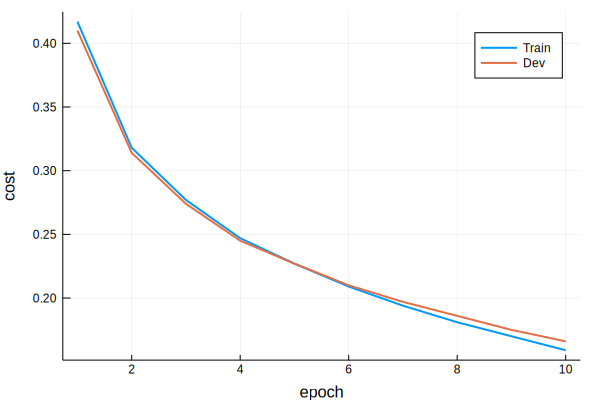

In [397]:
# Plot history
plot_history(history)

In [398]:
# Train accuracy
Yhat = predict(X, layers);
acc = accuracy(Y, Yhat)

0.9541666666666667

In [399]:
# Dev accuracy
Yhat_dev = predict(X_dev, layers);
# Accuracy
acc_dev = accuracy(Y_dev, Yhat_dev)

0.952

The single layer neural network with sigmoid activation function achieves a respectable dev set accuracy of $95.2$%. Towards the end of the training epochs, it starts to overfit on the training data.

### 3-layer model with ReLU activations, low dropout probability and batch size 64

By using a deeper model, we are likely to see an improvement over the baseline. We also use ReLU activations rather than sigmoid activations and apply dropout to each layer to mitigate the effects of overfitting (although rather unsuccesfully). 

In [413]:
layers, history = nnet(X, Y, n_h = (256, 128, 128), activations = ("ReLU", "ReLU", "ReLU"),
                       dropout_prop=(0.2, 0.2, 0.2), batch_size = 64, alpha = 0.001, epochs=10,
                       lr_decay=0, validation_split = 0.1);

Epoch 1:
	[train cost: 0.164] ==> [validation cost: 0.192]
	validation accuracy: 0.944
Epoch 2:
	[train cost: 0.105] ==> [validation cost: 0.142]
	validation accuracy: 0.956
Epoch 3:
	[train cost: 0.089] ==> [validation cost: 0.133]
	validation accuracy: 0.959
Epoch 4:
	[train cost: 0.066] ==> [validation cost: 0.111]
	validation accuracy: 0.966
Epoch 5:
	[train cost: 0.047] ==> [validation cost: 0.097]
	validation accuracy: 0.971
Epoch 6:
	[train cost: 0.043] ==> [validation cost: 0.101]
	validation accuracy: 0.971
Epoch 7:
	[train cost: 0.034] ==> [validation cost: 0.093]
	validation accuracy: 0.973
Epoch 8:
	[train cost: 0.029] ==> [validation cost: 0.089]
	validation accuracy: 0.974
Epoch 9:
	[train cost: 0.024] ==> [validation cost: 0.08]
	validation accuracy: 0.976
Epoch 10:
	[train cost: 0.024] ==> [validation cost: 0.089]
	validation accuracy: 0.976


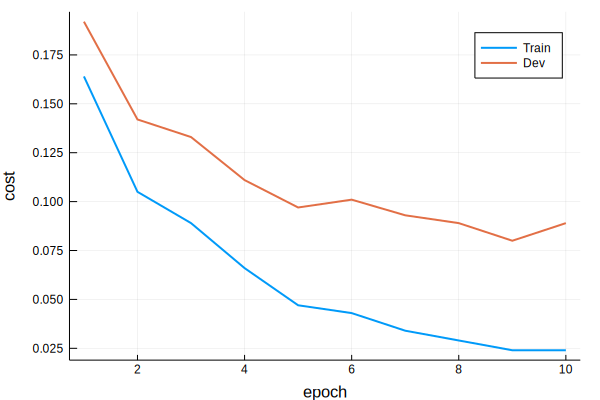

In [414]:
# Plot history
plot_history(history)

In [415]:
# Train accuracy
Yhat = predict(X, layers);
acc = accuracy(Y, Yhat)

0.9906

In [416]:
# Dev accuracy
Yhat_dev = predict(X_dev, layers);
# Accuracy
acc_dev = accuracy(Y_dev, Yhat_dev)

0.977

Even though we achieve a higher development set accuracy, it should be clear from the plot that we are overfitting rather heavily on the training data.

### Correcting for overfit

By increasing the dropout values and batch size, we try to reduce the overfit in the previous model, although we now run the risk of underfitting the model.

In [417]:
layers, history = nnet(X, Y, n_h = (256, 128, 128), activations = ("ReLU", "ReLU", "ReLU"),
                       dropout_prop=(0.7, 0.7, 0.7), batch_size = 128, alpha = 0.001, epochs=10,
                       lr_decay=0, validation_split = 0.1);

Epoch 1:
	[train cost: 0.847] ==> [validation cost: 0.853]
	validation accuracy: 0.798
Epoch 2:
	[train cost: 0.532] ==> [validation cost: 0.549]
	validation accuracy: 0.858
Epoch 3:
	[train cost: 0.407] ==> [validation cost: 0.431]
	validation accuracy: 0.892
Epoch 4:
	[train cost: 0.331] ==> [validation cost: 0.357]
	validation accuracy: 0.908
Epoch 5:
	[train cost: 0.285] ==> [validation cost: 0.31]
	validation accuracy: 0.917
Epoch 6:
	[train cost: 0.248] ==> [validation cost: 0.276]
	validation accuracy: 0.922
Epoch 7:
	[train cost: 0.222] ==> [validation cost: 0.249]
	validation accuracy: 0.93
Epoch 8:
	[train cost: 0.201] ==> [validation cost: 0.229]
	validation accuracy: 0.933
Epoch 9:
	[train cost: 0.189] ==> [validation cost: 0.219]
	validation accuracy: 0.936
Epoch 10:
	[train cost: 0.177] ==> [validation cost: 0.204]
	validation accuracy: 0.942


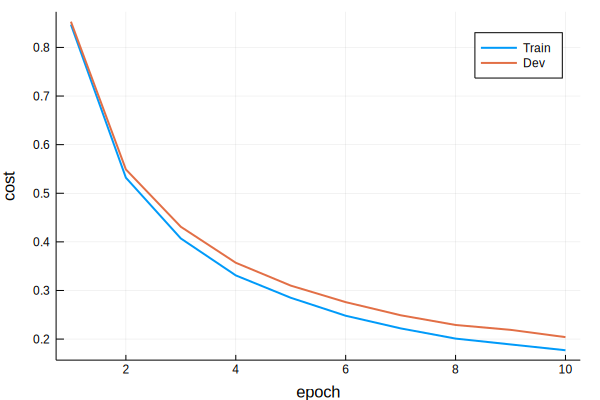

In [418]:
# Plot history
plot_history(history)

In [419]:
# Train accuracy
Yhat = predict(X, layers);
acc = accuracy(Y, Yhat)

0.9486666666666667

In [420]:
# Dev accuracy
Yhat_dev = predict(X_dev, layers);
# Accuracy
acc_dev = accuracy(Y_dev, Yhat_dev)

0.9472857142857143

We are still overfitting, though not as badly as before. However, the three-layer model performs less well than the single-layer model. Clearly, this is a problem. 

### The sweet spot

In [484]:
layers, history = nnet(X, Y, n_h = 512, activations = "ReLU", optimizer = "Adam",
                       dropout_prop=0.2, batch_size = 128, alpha = 0.001, epochs=8,
                       lr_decay=0, validation_split = 0.1);

Epoch 1:
	[train cost: 0.243] ==> [validation cost: 0.246]
	validation accuracy: 0.929
Epoch 2:
	[train cost: 0.178] ==> [validation cost: 0.182]
	validation accuracy: 0.946
Epoch 3:
	[train cost: 0.137] ==> [validation cost: 0.145]
	validation accuracy: 0.957
Epoch 4:
	[train cost: 0.106] ==> [validation cost: 0.117]
	validation accuracy: 0.966
Epoch 5:
	[train cost: 0.088] ==> [validation cost: 0.105]
	validation accuracy: 0.971
Epoch 6:
	[train cost: 0.073] ==> [validation cost: 0.095]
	validation accuracy: 0.974
Epoch 7:
	[train cost: 0.061] ==> [validation cost: 0.084]
	validation accuracy: 0.976
Epoch 8:
	[train cost: 0.054] ==> [validation cost: 0.08]
	validation accuracy: 0.976
Epoch 9:
	[train cost: 0.045] ==> [validation cost: 0.074]
	validation accuracy: 0.976
Epoch 10:
	[train cost: 0.038] ==> [validation cost: 0.071]
	validation accuracy: 0.979
Epoch 11:
	[train cost: 0.034] ==> [validation cost: 0.069]
	validation accuracy: 0.98
Epoch 12:
	[train cost: 0.03] ==> [validati

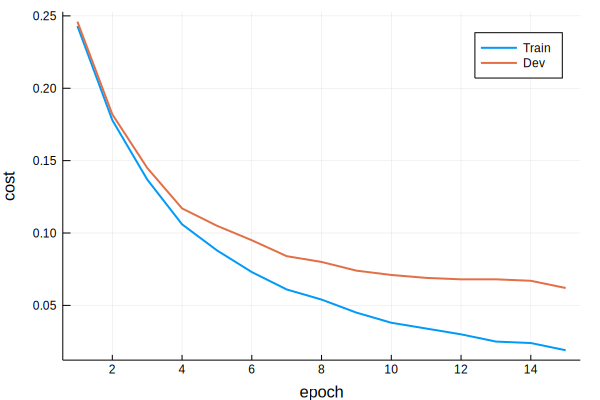

In [485]:
# Plot history
plot_history(history)

In [486]:
# Train accuracy
Yhat = predict(X, layers);
acc = accuracy(Y, Yhat)

0.9944833333333334

In [487]:
# Dev accuracy
Yhat_dev = predict(X_dev, layers);
# Accuracy
acc_dev = accuracy(Y_dev, Yhat_dev)

0.9812857142857143

### Predict on test data

In [488]:
# Test accuracy
Yhat_tst = predict(X_test, layers);
# Accuracy
acc_tst = accuracy(Y_test, Yhat_tst)

0.9816666666666667